# Door Dash Case Study

## Hypothesis:
*We anticipate pay rate, job function, location, tenure & total promotions are correlated with employee turnover*

## Method:
**Turnover Rate is defined as:**

$$
\text{Turnover Rate} = \left( \frac{\text{Number of Employees Who Left}}{\text{Total Employees}} \right) \times 100 \tag*{}
$$








- **Part 1** Analytics: Employee insights, key trends and factors driving employee turnover

- **Part 2** Predictive Modeling: 2025 Turnover forecast





### Library imports

# Part 2 Data Modeling

Now that we understand our data better we can prepare to model our turnover rate.

We define turnover rate as:

$$
\text{Turnover Rate} = \left( \frac{\text{Number of Employees Who Left}}{\text{Total Employees}} \right) \times 100 \tag*{}
$$

For analysis we will perform 2 methods:
- Analytics
- ML modeling

***Analytical Method***

Calculate average turnover rate by job function and use a standard forecasting method, and we will use this as our baseline.

***ML Modeling***

Use a random forest to predict when an employee will terminate, then use these values to calculate churn

In [99]:
# pip install shap

In [101]:
import pandas as pd
from pandas.plotting import table
import os
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import warnings

warnings.filterwarnings('ignore')  # Suppress warnings

## Analytical Method

*Process*
- Calculate churn by job function
- Visually inspect for seasonality
    - There are high degrees of seasonality at total level, forecasting at this level will yield poor results
        - We find minimal seasonality in Strategy&Ops, moderate seasonality in Engineering/Finance, and high level of seasonality in Sales/HR
        - Engineering & Finance follow similar patterns which could be grouped should we need higher data volume
- Forecast
    - We will create forecasting method at job level to construct a forecast

*Results*
- Our forecast yields positive results for most forecasts except for Strategy&Ops
    - this is likely due to lack of seasonality & exponential smoothing model attempting to fit seasonality
    - We could improve results by using a moving average or removing seasonality for that job function
    - Weighted MAPE for 2024 is 12.71%


In [7]:
df = pd.read_csv("../Data_Sources/moondash_data.csv") #using relative path to import data
df.head()

,effective_date,employee_id,job_function,location,job_level,employee_status,hire_date,pay_rate_type,role_volume_type
0,2022-03-31,16041,HR,"New York City, New York",L5,Active,2020-08-10,Salary,Low
1,2022-03-31,16449,Sales,"New York City, New York",L6,Active,2020-04-05,Salary,Low
2,2022-03-31,15822,Engineering,"San Francisco, California",L4,Active,2021-12-03,Salary,Low
3,2022-03-31,15417,Sales,"San Francisco, California",L5,Active,2021-08-01,Salary,Low
4,2022-03-31,14944,HR,"San Francisco, California",L4,Active,2021-03-01,Salary,Low


In [8]:
#converting locations into easier to work with values
df['location'] = df['location'].apply(lambda x: x.split(',')[0].replace(" ", ""))

#same with job function
df['job_function'] = df['job_function'].str.split(' ', n=1).str[0]

#convert dates from strings into datetime
df[['effective_date','hire_date']] = df[['effective_date','hire_date']].apply(pd.to_datetime)

#converting effective dates to quarterly to be used for time series modeling + graphs
df['effective_date'] = df['effective_date'].dt.to_period('Q').dt.start_time

df.head()


,effective_date,employee_id,job_function,location,job_level,employee_status,hire_date,pay_rate_type,role_volume_type
0,2022-01-01,16041,HR,NewYorkCity,L5,Active,2020-08-10,Salary,Low
1,2022-01-01,16449,Sales,NewYorkCity,L6,Active,2020-04-05,Salary,Low
2,2022-01-01,15822,Engineering,SanFrancisco,L4,Active,2021-12-03,Salary,Low
3,2022-01-01,15417,Sales,SanFrancisco,L5,Active,2021-08-01,Salary,Low
4,2022-01-01,14944,HR,SanFrancisco,L4,Active,2021-03-01,Salary,Low


In [9]:

# Group by 'effective_date' and 'job_function', and count the number of unique 'employee_id's
employee_count = df.groupby(['effective_date', 'job_function','employee_status'])['employee_id'].nunique().reset_index()

# Rename the 'employee_id' column to 'employee_count'
employee_count.rename(columns={'employee_id': 'employee_count'}, inplace=True)

# Display the result
employee_count[employee_count['effective_date'] == '2022-01-01'].sort_values(by = ['job_function','employee_status','effective_date']).head(5)


,effective_date,job_function,employee_status,employee_count
0,2022-01-01,Engineering,Active,1122
1,2022-01-01,Engineering,Terminated,47
2,2022-01-01,Finance,Active,212
3,2022-01-01,Finance,Terminated,4
4,2022-01-01,HR,Active,183


### Visual Inspection

We will compare forecast from both Total & Job Function level

#### Total

In [12]:
def calculate_churn(df, values, index, columns, aggfunc='sum'):
    # Pivot the table
    pivot_table = df.pivot_table(
        values=values,  # The column to aggregate
        index=index,  # Columns to group by
        columns=columns,  # Pivot by this column
        aggfunc=aggfunc  # Aggregation function
    )
    
    # Calculate churn as terminated over remaining employees for a given period
    if 'Active' in pivot_table.columns and 'Terminated' in pivot_table.columns:
        pivot_table['churn'] = round(pivot_table['Terminated'] / (pivot_table['Active'] + pivot_table['Terminated']), 4)
        pivot_table['total_employees'] = pivot_table['Active'] + pivot_table['Terminated']
    else:
        raise ValueError("Columns 'Active' and 'Terminated' must be present in the pivot table.")
    
    return pivot_table

In [13]:

tot_churn = calculate_churn(employee_count,'employee_count','effective_date','employee_status',aggfunc='sum')
tot_churn.head()

employee_status,Active,Terminated,churn,total_employees
effective_date,,,,
2022-01-01,4080,920,0.1840,5000
2022-04-01,3906,1094,0.2188,5000
2022-07-01,3979,1021,0.2042,5000
2022-10-01,3871,1129,0.2258,5000
2023-01-01,4663,1087,0.1890,5750


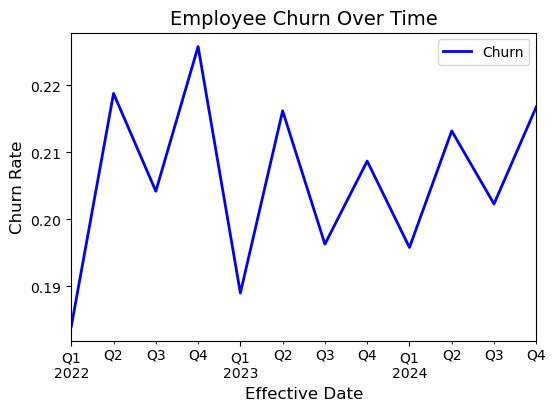

In [14]:
# Plot churn with added enhancements
ax = tot_churn['churn'].plot(figsize=(6, 4), color='b', linewidth=2)

# Adding labels and title
ax.set_xlabel('Effective Date', fontsize=12)
ax.set_ylabel('Churn Rate', fontsize=12)
ax.set_title('Employee Churn Over Time', fontsize=14)

# Adding a legend
ax.legend(['Churn'], loc='best')

# Show the plot
plt.show()


#### Job Function

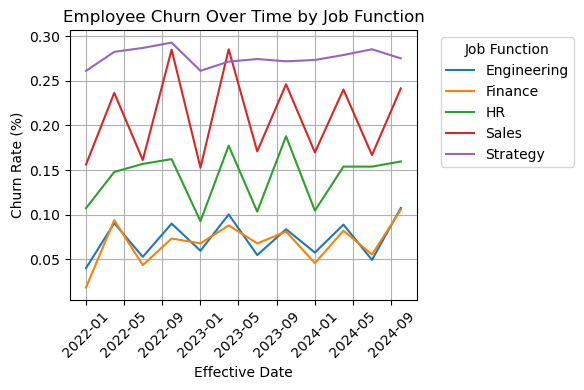

In [16]:
# Plotting the churn rate over time for each job function
##resetting index for easier visuals
job_churn = calculate_churn(employee_count,'employee_count',['effective_date','job_function']\
                            ,'employee_status',aggfunc='sum').reset_index()

# Assuming pivot_table2 is already reset and contains the necessary data

plt.figure(figsize=(6, 4))  # Adjusted figure size for better visibility

# Plot churn for each job function
for job in job_churn['job_function'].unique():
    job_data = job_churn[job_churn['job_function'] == job]
    plt.plot(job_data['effective_date'], job_data['churn'], label=job)

# Adding titles and labels
plt.title('Employee Churn Over Time by Job Function')
plt.xlabel('Effective Date')
plt.ylabel('Churn Rate (%)')

# Move legend outside the plot
plt.legend(title='Job Function', bbox_to_anchor=(1.05, 1), loc='upper left')

# Enable grid for better readability
plt.grid(True)
plt.xticks(rotation=45) 
# Adjust layout to prevent overlap of elements
plt.tight_layout()

# Show the plot
plt.show()

### Forecasting Method - Exponential Smoothing Training
Estimating yearly error

End goal is to forecast 4 periods (or 1 year). We have 12 quarters of data and will split the data as first 8 entries as training data & last 4 as testing data.

To keep things simplier we will set effective date as an index for each data set.

In [18]:
# Create a training set for 2022-2023 and test set for 2024
## setting index for date, for forecasts we will loop through each job type
train_data = job_churn[(job_churn['effective_date'].dt.year >= 2022) & \
(job_churn['effective_date'].dt.year <= 2023)].set_index('effective_date')

test_data = job_churn[job_churn['effective_date'].dt.year == 2024]

job_churn.set_index('effective_date',inplace = True)

#### Functions
Creating two functions to reduce code replication
- *exponential_fcst*
    - Iterate through each job function, create an exponential forecast & save into a dataframe
- *exponential_graphs*
    - Iterate through each job function & plot actual versus predicted

In [20]:
def exponential_fcst(df):
    # Empty DataFrame to save predictions
    archived_forecasts = pd.DataFrame(columns=['effective_date', 'job_function', 'forecast_churn'])

    # Loop through each job function and apply Exponential Smoothing
    for job in df['job_function'].unique():
        job_data = df[df['job_function'] == job]

        # Apply Exponential Smoothing
        model = ExponentialSmoothing(job_data['churn'], trend='add', seasonal='add', seasonal_periods=4)
        fit_model = model.fit()

        # Forecast for the next 4 quarters
        forecast = fit_model.forecast(steps=4)

        # Generate forecast dates (ensure proper quarterly frequency)
        forecast_dates = pd.date_range(start=job_data.index.max(), periods=5, freq='Q')[1:]  # Next 4 quarters

        # Store forecast values
        forecast_df = pd.DataFrame({
            'effective_date': forecast_dates,
            'job_function': [job] * len(forecast),
            'forecast_churn': forecast.values
        })

        # Append to archive DataFrame
        archived_forecasts = pd.concat([archived_forecasts, forecast_df], ignore_index=True)

    # Convert date column properly *after* all iterations
    archived_forecasts['effective_date'] = archived_forecasts['effective_date'].dt.to_period('Q').dt.start_time
    archived_forecasts.set_index('effective_date', inplace=True)

    return archived_forecasts

In [131]:
def exponential_graphs(actuals_df,forecast_df):
    # Loop through each job level and apply Exponential Smoothing

    
    for job in actuals_df['job_function'].unique():
        # Filter actual and forecasted values for the specific job function
        job_actuals = actuals_df[actuals_df['job_function'] == job]
        job_forecast = forecast_df[forecast_df['job_function'] == job]
    
        plt.figure(figsize=(6, 4))
    
        # Plot actual churn values
        plt.plot(job_actuals.index, job_actuals['churn'], label='Actual Churn', color='blue')
    
        # Plot forecasted churn values
        plt.plot(job_forecast.index, job_forecast['forecast_churn'], label='Forecasted Churn', color='red', linestyle='--')
    
        # Titles and labels
        plt.title(f'Employee Churn Forecast for {job}')
        plt.xlabel('Effective Date')
        plt.ylabel('Churn Rate')
        # plt.legend(title='Job Function')

        # plt.legend(title='Job Function', bbox_to_anchor=(1.05, 1), loc='upper left')

        # Rotate x-axis labels for better readability
        plt.xticks(rotation=45)
    
        # Show the plot
        plt.grid(True)
        plt.tight_layout()
        
        plt.savefig(f'../Output_Files/forecast_{job}.svg', format='svg')
    
       
        
        plt.show()
         # Clear the current figure after saving to avoid overlapping plots
        plt.clf()

#### Results Analytical Method

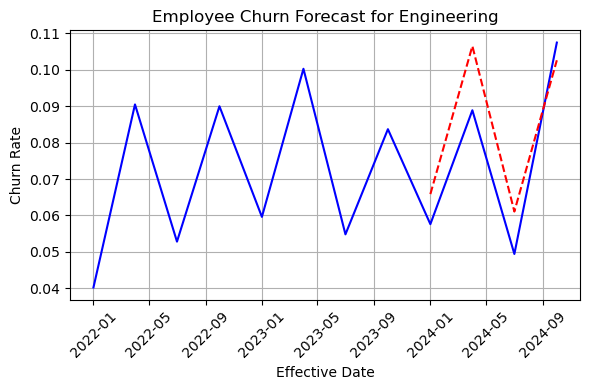

<Figure size 640x480 with 0 Axes>

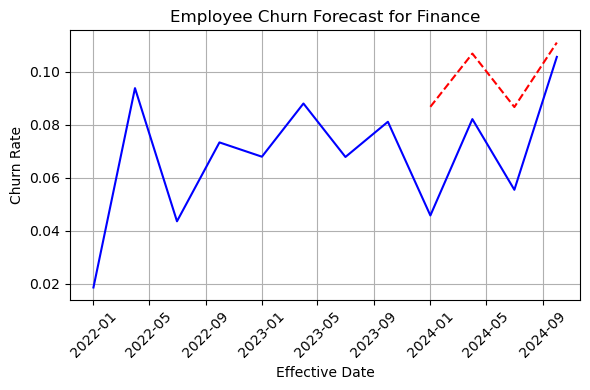

<Figure size 640x480 with 0 Axes>

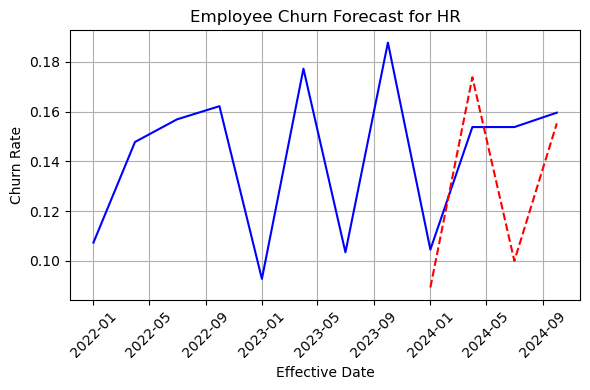

<Figure size 640x480 with 0 Axes>

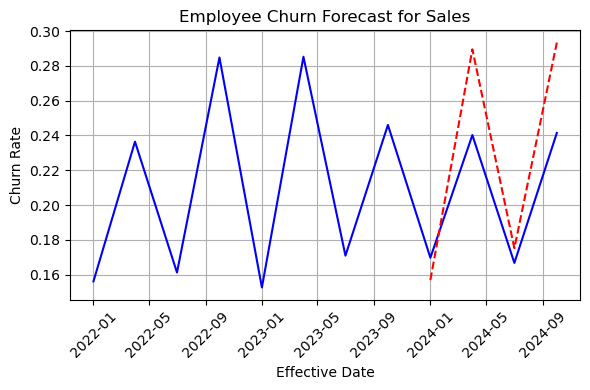

<Figure size 640x480 with 0 Axes>

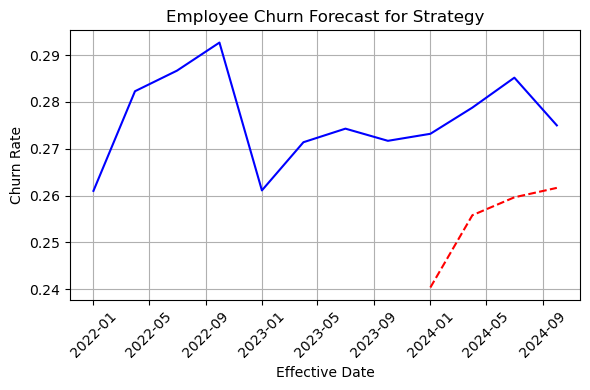

<Figure size 640x480 with 0 Axes>

In [133]:
#running our forecast on training set
archived_forecasts = exponential_fcst(train_data)

#graphing forecast comparing actuals to forecast
exponential_graphs(job_churn,archived_forecasts)

In [24]:
archived_forecasts.head()

,job_function,forecast_churn
effective_date,,
2024-01-01,Engineering,0.065861
2024-04-01,Engineering,0.106546
2024-07-01,Engineering,0.061065
2024-10-01,Engineering,0.102638
2024-01-01,Finance,0.086755


In [121]:
#combining our forecast data to actual data $ calculate MAPE
result_ts = pd.merge(test_data, archived_forecasts, on=['effective_date', 'job_function'], how='left')

result_ts['mape'] = abs((result_ts['churn'] - result_ts['forecast_churn']) / result_ts['churn'])

#getting total staff by effective date
total_staff = result_ts[['effective_date','total_employees']].groupby('effective_date').sum().reset_index().rename(columns={'total_employees':'tot_quart_employ'})

#mapping total staff back into data frame
result_ts2 = pd.merge(result_ts, total_staff, on=['effective_date'], how='left')

#calculating weighted mape by quarter for each job level
result_ts2['wgt_mape'] = result_ts2['mape'] * (result_ts2['total_employees'] / result_ts2['tot_quart_employ'])

#rolling weighted mape to quarter
qtr_mape = result_ts2[['effective_date', 'wgt_mape']].groupby('effective_date').sum()

#averaging results (same amount of staff each quarter so no additional weighting is needed)
f"The weighted average MAPE across 2023 data is {qtr_mape['wgt_mape'].mean():.4f}"

'The weighted average MAPE across 2023 data is 0.1271'

### Forecasting Method - Exponential Smoothing Predicting
Forecasting next year of churn

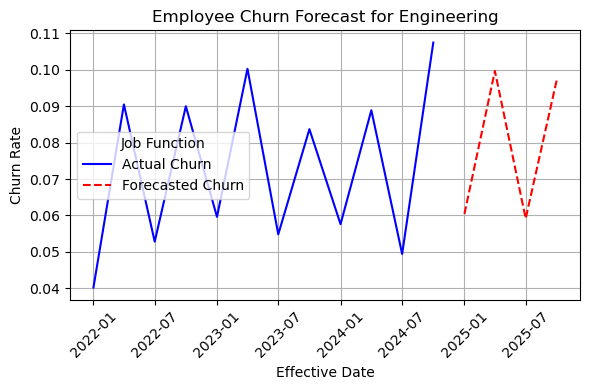

<Figure size 640x480 with 0 Axes>

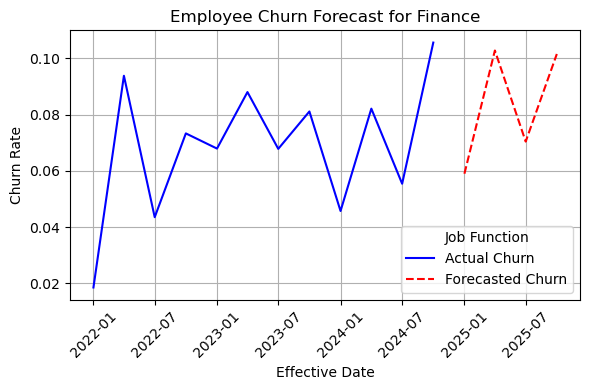

<Figure size 640x480 with 0 Axes>

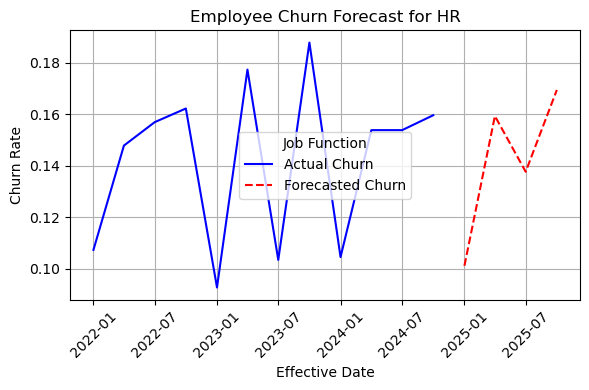

<Figure size 640x480 with 0 Axes>

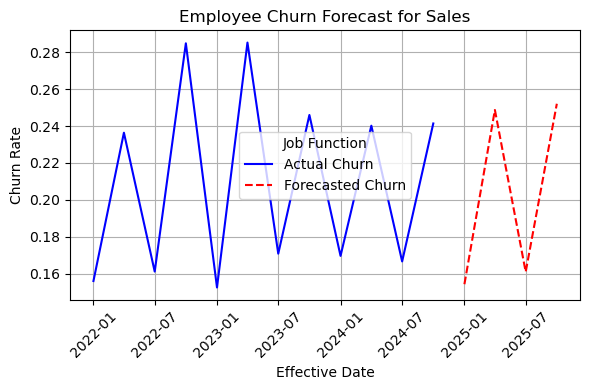

<Figure size 640x480 with 0 Axes>

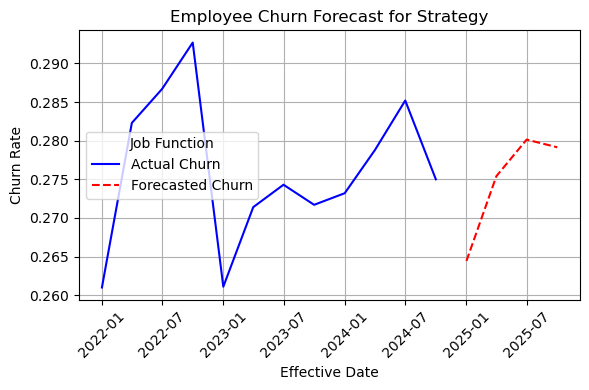

We expect overall churn to be 0.1567

We expect churn by job function to be


<Figure size 640x480 with 0 Axes>

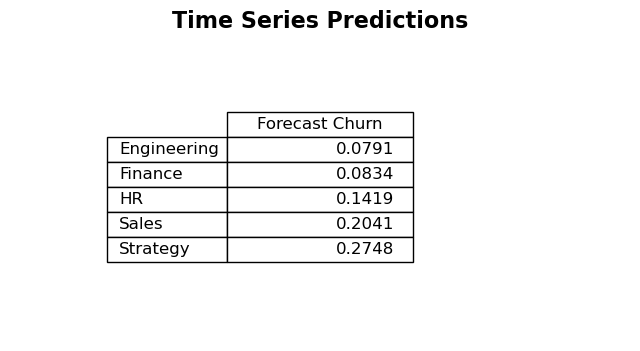

In [125]:
prediction = exponential_fcst(job_churn)

# Optional: Run the function for prediction graphs if needed
exponential_graphs(job_churn, prediction) 

# Saving predictions to CSV by job type & quarter
prediction.to_csv('../Output_Files/exponential_predictions.csv', index=True)

# Print overall churn expectation
print("We expect overall churn to be " + str(round(prediction['forecast_churn'].mean(), 4)))
print("")
print("We expect churn by job function to be")

# Aggregating data by job function for export
agg_df = round(prediction[['job_function', 'forecast_churn']].groupby('job_function').mean(), 4)
agg_df.rename(columns = {'forecast_churn':'Forecast Churn'},inplace = True) #renaming for a cleaner export

fig, ax = plt.subplots(figsize=(8, 4))  # Set the size of the figure
ax.axis('off')  # Hide the axis

# Set the title and reduce the space between the title and table
ax.set_title('Time Series Predictions', fontsize=16, weight='bold', loc='center', pad=1)

# Use pandas plotting to create a table in the plot
tbl = table(ax, agg_df, loc='center', colWidths=[0.2]*len(df.columns))

# Customize the table (optional)
tbl.auto_set_font_size(False)
tbl.set_fontsize(12)
tbl.scale(1.5, 1.5)  # Scale the table for better readability

# Save the plot as an image
plt.savefig('../Output_Files/ts_class_pred.svg', bbox_inches='tight', pad_inches=0.1)

# Show the plot (optional)
plt.show()


## ML Method

*Process*
- Using our output table from part 1 use a XGBOOST random forecast to predict when an employee will quit
    - output will be 1/0 (Classification Method)
    - explanatory variables include
        - Total
        - Current Role Tenure
        - Number of Promotions
        - Job Function
        - Pay Type
        - Location
        - Job Level
- Map in termination accuracy back to employee to calculate accuracy
- Compare ML to Analytical Method and provide final recommendations
  
*Results*

### Prepping Data
Calculating explantory variables & converting categorical variables into dummy variables

In [30]:
df_stage = pd.read_csv("../Data_Sources/ML_input.csv") #using relative path to import data
# )
df_stage.groupby('employee_status').count()

,employee_id,effective_date,job_function,job_level,pay_rate_type,location,max_tenure,max_role_tenure,max_promotions
employee_status,,,,,,,,,
Active,5091,5091,5091,5091,5091,5091,5091,5091,5091
Terminated,9805,9805,9805,9805,9805,9805,9805,9805,9805


In [31]:
#getting dummy variables
df_final = pd.get_dummies(df_stage, columns=['employee_status','job_function', 'pay_rate_type', 'location','job_level'], drop_first=False)

#creating filters for prediction variable & selected dropped variable
#prediction variable
y_var_names = ['employee_status_Terminated']

#dropped dummy variables
excluded_var_names = ['effective_date','job_function_Engineering','employee_status_Active','location_NewYorkCity','job_level_L3'] 

#dummys are returned as T/F, we use astype.(int) to convert to 1/0
df_final2 = df_final.drop(columns = excluded_var_names).astype(int)

#creating key of job functions & terminations to maintain same mix in train/test sets 
df_final2['class_var'] = df_final2[['employee_status_Terminated','job_function_Finance',\
                                  'job_function_HR','job_function_Sales','job_function_Strategy']].apply(lambda row: '_'.join(row.astype(str)), axis=1)

#dropping engineering 
df_final2.head()

,employee_id,max_tenure,max_role_tenure,max_promotions,employee_status_Terminated,job_function_Finance,job_function_HR,job_function_Sales,job_function_Strategy,pay_rate_type_Hourly,...,location_Tempe,job_level_L10,job_level_L2,job_level_L4,job_level_L5,job_level_L6,job_level_L7,job_level_L8,job_level_L9,class_var
0,1,796,796,1,1,0,0,0,1,1,...,0,0,1,0,0,0,0,0,0,1_0_0_0_1
1,3,679,679,1,1,0,0,0,1,1,...,0,0,1,0,0,0,0,0,0,1_0_0_0_1
2,6,622,622,1,1,0,0,0,1,1,...,0,0,1,0,0,0,0,0,0,1_0_0_0_1
3,7,1182,1182,1,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1_0_0_0_1
4,8,674,674,1,1,0,0,0,1,1,...,0,0,1,0,0,0,0,0,0,1_0_0_0_1


In [32]:

# #setting up training & test data
# Perform train/test split while stratifying by the combined dummy variable
X_train_ml, X_test_ml, y_train_ml, y_test_ml = train_test_split(
    df_final2.drop(columns=['class_var']),  # Features (drop 'class_var')
    df_final2['employee_status_Terminated'],  # Target variable
    test_size=0.3,  # 30% for testing
    stratify=df_final2['class_var'],  # Stratify by 'class_var' column
    random_state=42
)

# Check the distribution of 'employee_status_Terminated' in train and test sets
print("Train set distribution:\n", y_train_ml.value_counts())
print("Test set distribution:\n", y_test_ml.value_counts())
print(X_train_ml[['job_function_Finance', 'job_function_HR','job_function_Sales','job_function_Strategy']].sum())
print(X_test_ml[['job_function_Finance', 'job_function_HR','job_function_Sales','job_function_Strategy']].sum())

Train set distribution:
 employee_status_Terminated
1    6864
0    3563
Name: count, dtype: int64
Test set distribution:
 employee_status_Terminated
1    2941
0    1528
Name: count, dtype: int64
job_function_Finance      359
job_function_HR           305
job_function_Sales        520
job_function_Strategy    7365
dtype: int64
job_function_Finance      154
job_function_HR           131
job_function_Sales        223
job_function_Strategy    3156
dtype: int64


In [33]:

# First split: Train (70%) and Temporary (30%)
X_train_ml, X_temp_ml, y_train_ml, y_temp_ml = train_test_split(
    df_final2.drop(columns=['class_var','employee_status_Terminated','employee_id']),  # Features (drop 'class_var')
    df_final2['employee_status_Terminated'],  # Target variable
    test_size=0.30,  # 30% for temporary (Test + Validation)
    stratify=df_final2['class_var'],  # Stratify by 'class_var' column
    random_state=42
)

# Second split: Temporary into Test (50%) and Validation (50%)
X_test_ml, X_val_ml, y_test_ml, y_val_ml = train_test_split(
    X_temp_ml,  # Temporary features
    y_temp_ml,  # Temporary target
    test_size=0.5,  # 50% of the temporary data for validation
    stratify=y_temp_ml,  # Stratify by the target variable
    random_state=42
)

# Check the shape of each split
print(f'X_train_ml shape: {X_train_ml.shape}')
print(f'X_test_ml shape: {X_test_ml.shape}')
print(f'X_val_ml shape: {X_val_ml.shape}')

X_train_ml shape: (10427, 23)
X_test_ml shape: (2234, 23)
X_val_ml shape: (2235, 23)


In [103]:
# Initialize model
clf = XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False)

# Train model on training data
clf.fit(X_train_ml, y_train_ml)

# Validate model on validation data (optional, for hyperparameter tuning or early stopping)
y_val_pred = clf.predict(X_val_ml)
val_accuracy = accuracy_score(y_val_ml, y_val_pred)
print(f'Validation Accuracy: {val_accuracy:.4f}')

# Predict on test data
y_test_pred = clf.predict(X_test_ml)

# Evaluate accuracy on test data
test_accuracy = accuracy_score(y_test_ml, y_test_pred)
print(f'Test Accuracy: {test_accuracy:.4f}')

Validation Accuracy: 0.8461
Test Accuracy: 0.8362


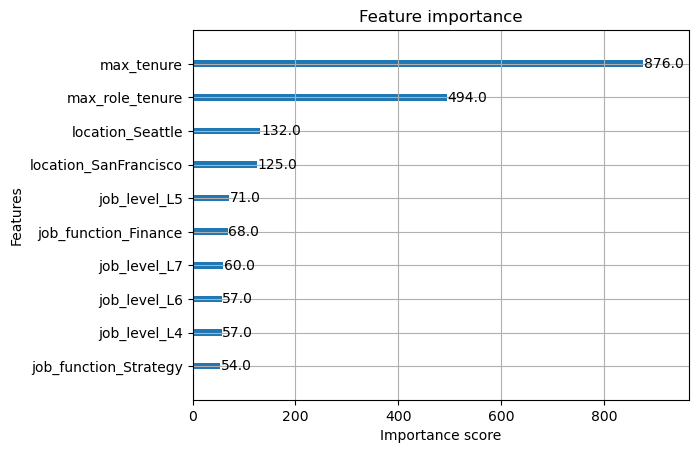

In [88]:

# Visualize feature importances
plot_importance(clf, importance_type='weight', max_num_features=10)
plt.savefig('../Output_Files/xgboost_importance.svg', bbox_inches='tight')  # Save as svg
plt.show()


#### Make Predictions on all of our active Employees

In [37]:
#using our final prepped df but filtering to all active employees
final_pred_df = df_final2[df_final2['employee_status_Terminated'] == 0]\
                .drop(columns = ['employee_status_Terminated','employee_id','class_var'])

# Making new predictions
new_predictions = clf.predict(final_pred_df)

# Creating a DataFrame with predictions and employee_id for merging
predictions_df = pd.DataFrame({
    'employee_id': df_final2[df_final2['employee_status_Terminated'] == 0]['employee_id'], 
    'predictions': new_predictions
})

# Mapping predictions back to the original dataframe based on 'employee_id'
final_pred_df2 = pd.merge(df_stage, predictions_df, how='inner', on='employee_id')

# Using .agg() to get both count and sum for each 'job_function'
final_pred_df3 = final_pred_df2[['job_function', 'predictions']].groupby('job_function').agg(
    count=('predictions', 'count'),  # Count the number of predictions for each job_function
    sum=('predictions', 'sum')      # Sum of predictions for each job_function (number of terminated employees)
).rename(columns={'count': 'Total Employees', 'sum': 'Term Employees'})

# Calculate termination rate by job function
final_pred_df3['Term Rate'] = round(final_pred_df3['Term Employees'] / final_pred_df3['Total Employees'], 4)

# Display the aggregated dataframe
print("We expect Employee Attrition Rate across all job types to be " + 
      str(round(final_pred_df3['Term Employees'].sum() / final_pred_df3['Total Employees'].sum(), 4)))

print("")
print("Employee Attrition across job type:")
# Correct the column selection
print(final_pred_df3['Term Rate'])


We expect Employee Attrition Rate across all job types to be 0.2609

Employee Attrition across job type:
job_function
Engineering    0.0509
Finance        0.0262
HR             0.1139
Sales          0.2841
Strategy       0.4045
Name: Term Rate, dtype: float64


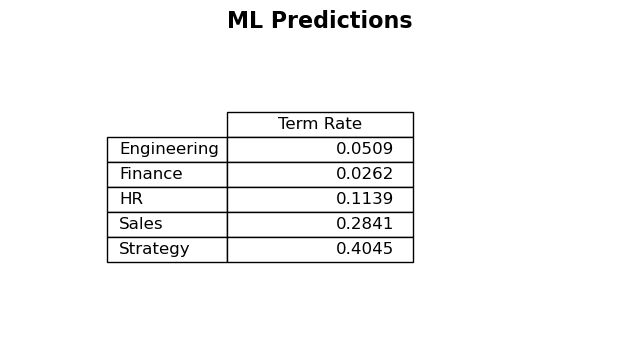

In [93]:


fig, ax = plt.subplots(figsize=(8, 4))  # Set the size of the figure
ax.axis('off')  # Hide the axis

# Set the title and reduce the space between the title and table
ax.set_title('ML Predictions', fontsize=16, weight='bold', loc='center', pad=1)

# Use pandas plotting to create a table in the plot
tbl = table(ax, final_pred_df3['Term Rate'], loc='center', colWidths=[0.2]*len(df.columns))

# Customize the table (optional)
tbl.auto_set_font_size(False)
tbl.set_fontsize(12)
tbl.scale(1.5, 1.5)  # Scale the table for better readability

# Save the plot as an image
plt.savefig('../Output_Files/xgboost_class_pred.svg', bbox_inches='tight', pad_inches=0.1)

# Show the plot (optional)
plt.show()
